## **Setting up the environment**

In [1]:
# NLP libraries
import re
import spacy
import preprocessor as p
import tagme
from collections import Counter

# Analysis libraries
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_colwidth", None)

In [3]:
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.4 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## **Loading the data**

We will load the HatEval dataset. It is a dataset about violence against immigrants and women.

In [4]:
train_df = pd.read_csv("./source_data/train_en.tsv", sep="\t")
dev_df = pd.read_csv("./source_data/dev_en.tsv", sep="\t")
data_df = pd.concat([train_df, dev_df])

In [5]:
data_df.head()

,id,text,HS,TR,AG
0,201,"Hurray, saving us $$$ in so many ways @potus @realDonaldTrump #LockThemUp #BuildTheWall #EndDACA #BoycottNFL #BoycottNike",1,0,0
1,202,"Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe.... https://t.co/Ks0SHbtYqn",1,0,0
2,203,"@KamalaHarris Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal #FamilesBelongTogether in their Country not on the Taxpayer Dime Its a SCAM #NoDACA #NoAmnesty #SendThe",1,0,0
3,204,NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants https://t.co/ACZKLhdMV9 https://t.co/CJAlSXCzR6,0,0,0
4,205,"Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants https://t.co/NeYFyqvYlX",0,0,0


In [6]:
data_df.shape

(10000, 5)

The dataset contains 10000 tweets.

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  int64 
 1   text    10000 non-null  object
 2   HS      10000 non-null  int64 
 3   TR      10000 non-null  int64 
 4   AG      10000 non-null  object
dtypes: int64(3), object(2)
memory usage: 468.8+ KB


*   **id** is an unique identifier of the tweet
*   **text** is the content of the tweet
*   **HS** (**Hate Speech**) is to say if the tweet is hate speech or not
*   **TR** (**Targeted Recipient**) is to say if the tweet is against a group of people or a particular individual (in the case it is an hate speech)
*   **AG** (**Aggressiveness**) is to say if the tweet is aggressive or not (in the case it is an hate speech)

## **Preprocessing the data**

In [8]:
data_df.isna().sum()

id      0
text    0
HS      0
TR      0
AG      0
dtype: int64

In [9]:
data_df.duplicated().sum()

np.int64(0)

In [10]:
# We don't need the id column for our analysis so, we remove it.

data_df = data_df.drop(columns=["id"])

We notice through the call of info() method earlier that AG is considered an object column meanwhile it should only contain 0 or 1.

In [11]:
data_df["AG"].unique()

array(['0', '1', 'discredit', 0, 1], dtype=object)

It seems there is a problematic value called "discredit" here and we have also some 0 and 1 that are interpreted as strings. Let's clean that.

In [12]:
data_df["AG"].value_counts()

AG
0            7440
1            1559
0             796
1             204
discredit       1
Name: count, dtype: int64

We have more 0 than 1. So, we will replace discredit by 0 and cast all the column to int.

In [13]:
data_df.loc[data_df["AG"] == "discredit", "AG"] = 0
data_df["AG"] = data_df["AG"].astype(int)

In [14]:
data_df["AG"].value_counts()

AG
0    8237
1    1763
Name: count, dtype: int64

### **Step 1 : Clean the tweets**

We will have two levels of cleaning for the tweets. The first one will be the level we obtain by applying the clean method of tweet preprocessor. This one will remove links, mentions and hashtags. The second one will be the classic approaches (lemmatization, removing stopwords, etc.). It will be done after the first one.

Note that we will use the first level to get the entities and the second level to analyze the tweets later.

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
def preprocess(text):
    # Lowercasing the characters
    text = text.strip().lower()
    # Removing of special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Lemmatization + Stopwords/Punctuations removal
    tokens = nlp(text)
    filtered_tokens = []
    for token in tokens:
        if ((len(token.text.strip()) > 1) and (token.pos_ not in ["PRON", "PUNCT"])
        and (not token.text in nlp.Defaults.stop_words)):
            if (not token.lemma_ in nlp.Defaults.stop_words):
                filtered_tokens.append(str(token.lemma_))
    return " ".join(filtered_tokens)

In [17]:
# First level (removal of links)
data_df["tweet_1"] = data_df["text"].apply(p.clean)

# Second level (first level + lemmatization + stopwords and punctuations removal)
data_df["tweet_2"] = data_df["tweet_1"].apply(preprocess)

In [18]:
data_df["tweet_1"].str[:70].head()

0                                     Hurray, saving us $$$ in so many ways
1    Why would young fighting age men be the vast majority of the ones esca
2    Illegals Dump their Kids at the border like Road Kill and Refuse to Un
3    NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Im
4    Orban in Brussels: European leaders are ignoring the will of the peopl
Name: tweet_1, dtype: object

In [19]:
data_df["tweet_2"].str[:70].head()

0                                                           hurray save way
1    young fighting age man vast majority escape war amp fight like woman c
2    illegal dump kid border like road kill refuse unite hope amnesty free 
3                   ny time nearly white state pose array problem immigrant
4                 orban brussels european leader ignore people want migrant
Name: tweet_2, dtype: object

### **Step 2 : Get the mentions/personalities**

In [20]:
def get_mentions(text):
    return re.findall(r"@\w+", text)

In [21]:
get_mentions("Hello, @user1! How are you doing? @another_user and @test are here.")

['@user1', '@another_user', '@test']

In [22]:
data_df["mentions"] = data_df["text"].apply(get_mentions)

In [23]:
data_df["mentions"].head()

0    [@potus, @realDonaldTrump]
1                            []
2               [@KamalaHarris]
3                            []
4                            []
Name: mentions, dtype: object

### **Step 3 : Get the themes**

In [24]:
# It is token created using a temporary mail. So there are no security issues.
tagme.GCUBE_TOKEN = "8dd02590-fe1f-41b2-a9d9-ca34da522ebe-843339462"

def extract_entities(text):
    annotation = tagme.annotate(text)
    entities = {}
    if annotation:
        entities = {entity.entity_title for entity in annotation.annotations if entity.score > 0.1}
    return list(entities)

In [25]:
extract_entities("trump immigration policy bad")

['Immigration to the United States', 'Donald Trump']

In [26]:
# Due to computation issues, the following code can't be executed.
# So, we formerly do batch extractions and combine all the results in a file that will be loaded each time 

# data_df["entities"] = data_df["tweet_1"].apply(extract_entities)
# ast.literal is to convert string to list

# Loading of entities extracted

data_df["themes"] = pd.read_csv("./computed_data/entities.csv")["entities"].apply(ast.literal_eval)

In [27]:
data_df["themes"].head()

0                                                                                      []
1       [Refugee, Domestic violence, Old age, Age of majority, Europe, Neil Young, Child]
2    [Nation state, Amnesty International, Welfare, Fraud, Roadkill, Law, Free education]
3        [U.S. state, Race and ethnicity in the United States Census, The New York Times]
4               [Brussels, Viktor Orbán, Popular sovereignty, Leadership, European Union]
Name: themes, dtype: object

Move name entities to mentions list

In [28]:
def update_themes(row):
    updated_themes = []
    mentions = row["mentions"]
    for entity in row["themes"]:
        tokens = nlp(entity)
        for token in tokens.ents:
            if token.label_ == "PERSON":
                mentions.append(token.text)
            else:
                updated_themes.append(token.text)
    row["themes"] = updated_themes
    row["mentions"] = mentions
    return row

In [29]:
data_df.head()

,text,HS,TR,AG,tweet_1,tweet_2,mentions,themes
0,"Hurray, saving us $$$ in so many ways @potus @realDonaldTrump #LockThemUp #BuildTheWall #EndDACA #BoycottNFL #BoycottNike",1,0,0,"Hurray, saving us $$$ in so many ways",hurray save way,"[@potus, @realDonaldTrump]",[]
1,"Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe.... https://t.co/Ks0SHbtYqn",1,0,0,"Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe....",young fighting age man vast majority escape war amp fight like woman child elderlyit majority refugee actually refugee economic migrant try europe,[],"[Refugee, Domestic violence, Old age, Age of majority, Europe, Neil Young, Child]"
2,"@KamalaHarris Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal #FamilesBelongTogether in their Country not on the Taxpayer Dime Its a SCAM #NoDACA #NoAmnesty #SendThe",1,0,0,"Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal in their Country not on the Taxpayer Dime Its a SCAM",illegal dump kid border like road kill refuse unite hope amnesty free education welfare illegal country taxpayer dime scam,[@KamalaHarris],"[Nation state, Amnesty International, Welfare, Fraud, Roadkill, Law, Free education]"
3,NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants https://t.co/ACZKLhdMV9 https://t.co/CJAlSXCzR6,0,0,0,NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants,ny time nearly white state pose array problem immigrant,[],"[U.S. state, Race and ethnicity in the United States Census, The New York Times]"
4,"Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants https://t.co/NeYFyqvYlX",0,0,0,"Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants",orban brussels european leader ignore people want migrant,[],"[Brussels, Viktor Orbán, Popular sovereignty, Leadership, European Union]"


In [30]:
data_df = data_df.apply(update_themes, axis=1)

In [31]:
data_df = data_df.rename(columns={"text": "tweet"})

In [32]:
data_df = data_df[["tweet", "tweet_1", "tweet_2", "mentions", "themes", "HS", "TR", "AG"]]

In [33]:
data_df.head()

,tweet,tweet_1,tweet_2,mentions,themes,HS,TR,AG
0,"Hurray, saving us $$$ in so many ways @potus @realDonaldTrump #LockThemUp #BuildTheWall #EndDACA #BoycottNFL #BoycottNike","Hurray, saving us $$$ in so many ways",hurray save way,"[@potus, @realDonaldTrump]",[],1,0,0
1,"Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe.... https://t.co/Ks0SHbtYqn","Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe....",young fighting age man vast majority escape war amp fight like woman child elderlyit majority refugee actually refugee economic migrant try europe,[Neil Young],[Europe],1,0,0
2,"@KamalaHarris Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal #FamilesBelongTogether in their Country not on the Taxpayer Dime Its a SCAM #NoDACA #NoAmnesty #SendThe","Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal in their Country not on the Taxpayer Dime Its a SCAM",illegal dump kid border like road kill refuse unite hope amnesty free education welfare illegal country taxpayer dime scam,[@KamalaHarris],"[Amnesty International, Fraud]",1,0,0
3,NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants https://t.co/ACZKLhdMV9 https://t.co/CJAlSXCzR6,NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants,ny time nearly white state pose array problem immigrant,[],"[U.S., the United States Census, The New York Times]",0,0,0
4,"Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants https://t.co/NeYFyqvYlX","Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants",orban brussels european leader ignore people want migrant,[Viktor Orbán],"[Brussels, European Union]",0,0,0


In [34]:
data_df.to_csv("./computed_data/hatEval.csv", index=False)

## **Analyzing the data**

#### **Distribution of the speeches**

In [35]:
data_df["HS"].value_counts()

HS
0    5790
1    4210
Name: count, dtype: int64

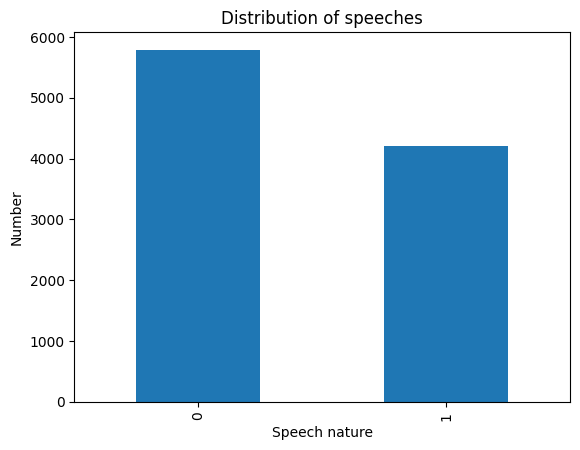

In [36]:
data_df["HS"].value_counts().plot(kind="bar", xlabel="Speech nature", ylabel="Number",
                                  title="Distribution of speeches")
plt.show()

There are **5790 normal tweets** and **4210 hate tweets**.

Let's analyze each type of tweet.

In [37]:
violent_tweets = data_df[data_df["HS"] == 1]
non_violent_tweets = data_df[data_df["HS"] == 0]

#### **Counts and Lengths of the tweets**

In [38]:
print("Average length of violent tweets: ", violent_tweets["tweet_1"].str.len().mean())
print("Average length of non violent tweets: ", non_violent_tweets["tweet_1"].str.len().mean())

Average length of violent tweets:  111.64109263657957
Average length of non violent tweets:  108.15112262521589


In [39]:
def count_words(text):
    return (len(text.split(" ")))

In [40]:
print("Average number of words of violent tweets: ", violent_tweets["tweet_1"].apply(count_words).mean())
print("Average number of words of non violent tweets: ", non_violent_tweets["tweet_1"].apply(count_words).mean())

Average number of words of violent tweets:  20.326365795724467
Average number of words of non violent tweets:  19.117098445595854


The size is not really a factor to differentiate an hate speech from an non-hate speech.

#### **Frequent words in each type of tweet**

In [41]:
# Most frequent words in violent tweets
violent_words = [word for tweet in violent_tweets["tweet_2"] for word in tweet.split()]
common_violent_words = Counter(violent_words).most_common(20)

# Most frequent words in non-violent tweets
non_violent_words = [word for tweet in non_violent_tweets["tweet_2"] for word in tweet.split()]
common_non_violent_words = Counter(non_violent_words).most_common(20)

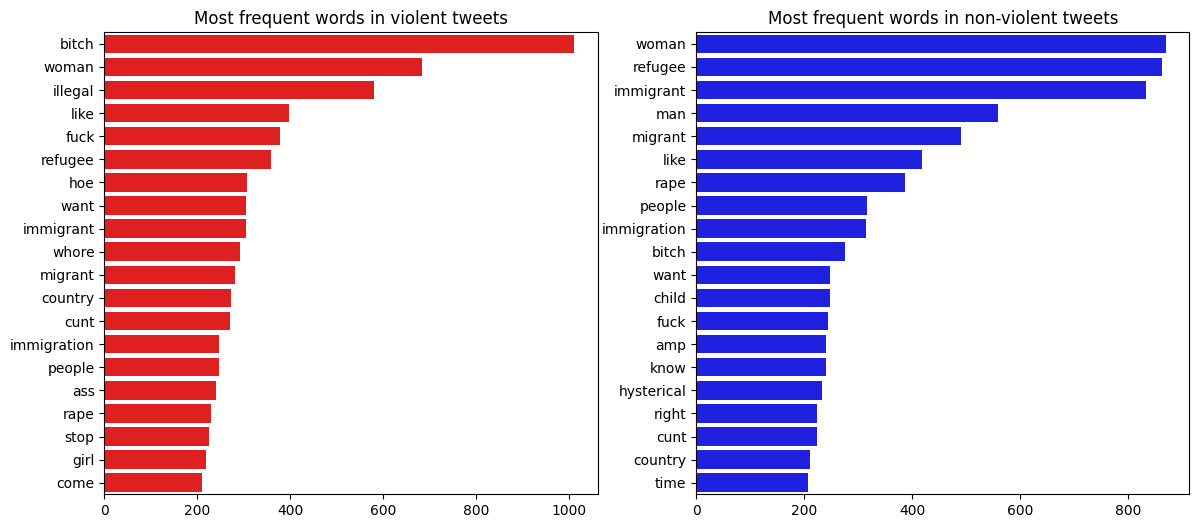

In [42]:
# Frequent word display
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x=[w[1] for w in common_violent_words], y=[w[0] for w in common_violent_words], ax=ax[0], color="red")
ax[0].set_title("Most frequent words in violent tweets")

sns.barplot(x=[w[1] for w in common_non_violent_words], y=[w[0] for w in common_non_violent_words], ax=ax[1], color="blue")
ax[1].set_title("Most frequent words in non-violent tweets")

plt.show()

#### **Frequent mentions in each type of tweet**

Let's analyze the frequent personalities.

In [43]:
def count_personalities(df):
    all_personalities = [person for sublist in df["mentions"] for person in sublist]
    return Counter(all_personalities).most_common(20)  # Top 20

In [44]:
hate_personalities = count_personalities(violent_tweets)
non_hate_personalities = count_personalities(non_violent_tweets)
df_hate = pd.DataFrame(hate_personalities, columns=["Mentions", "Occurence"])
df_non_hate = pd.DataFrame(non_hate_personalities, columns=["Mentions", "Occurence"])

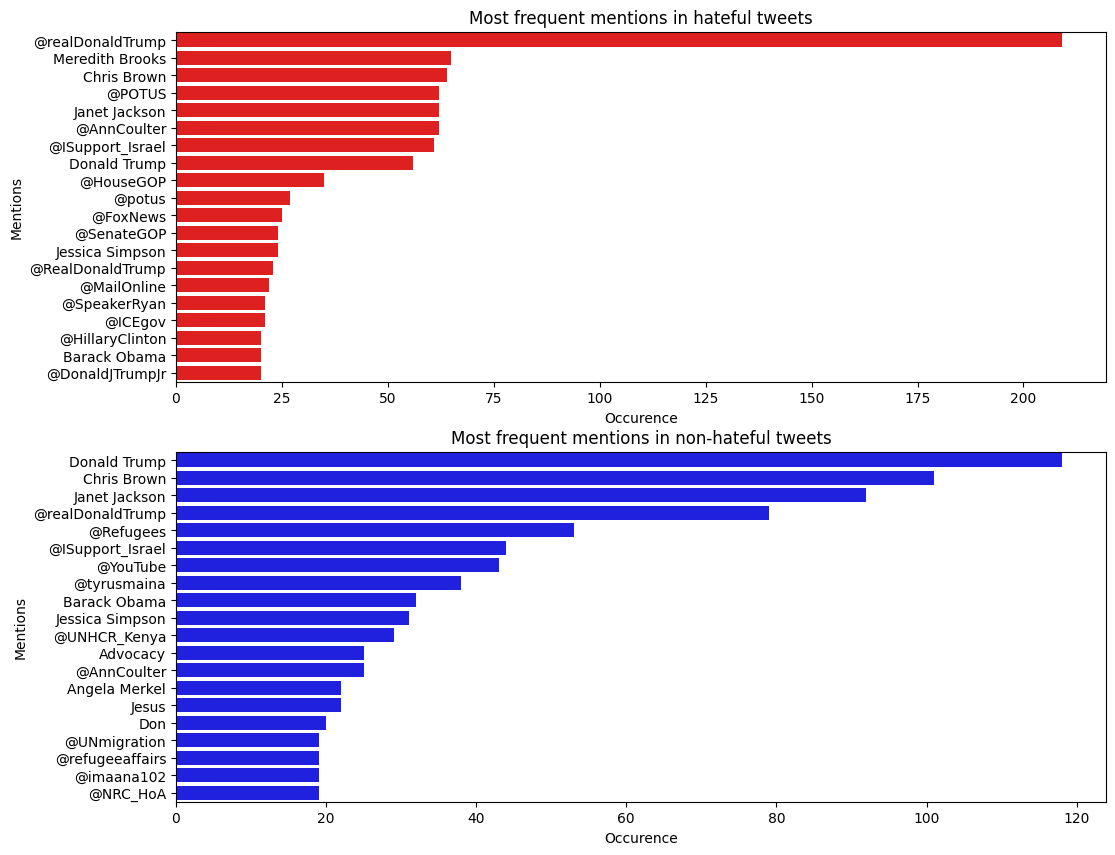

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Graphique pour les tweets haineux
sns.barplot(data=df_hate, x="Occurence", y="Mentions", ax=ax[0], color="red")
ax[0].set_title("Most frequent mentions in hateful tweets")

# Graphique pour les tweets non haineux
sns.barplot(data=df_non_hate, x="Occurence", y="Mentions", color="blue")
ax[1].set_title("Most frequent mentions in non-hateful tweets")

plt.show()

## **Sources**

* https://github.com/marcocor/tagme-python
* https://github.com/s/preprocessor
* https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list